In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(style="ticks", rc=custom_params)
sns.set_context("notebook", font_scale=1.1)

basedir = Path("../analysis/nfcore_sarek_rerun/multiqc/250218/multiqc_data")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

## Duplication

In [2]:
dups = pd.read_csv(basedir / "multiqc_picard_dups.txt", sep="\t")
dups["run"] = dups["Sample"].str.split(" | ",expand=True)[0]
dups["cell"] = dups["Sample"].str.split(" | ",expand=True)[2].str.split("-", expand=True)[0]
dups["Data source"] = dups["run"].replace(run_names)
dups["Data source"] = dups["Data source"].astype("category")
dups["Data source"] = dups["Data source"].cat.reorder_categories(run_names.values())
# https://github.com/MultiQC/MultiQC/blob/main/multiqc/modules/picard/MarkDuplicates.py#L235
# dups = d["UNPAIRED_READ_DUPLICATES"] + d["READ_PAIR_DUPLICATES"] * 2
# examined = d["UNPAIRED_READS_EXAMINED"] + d["READ_PAIRS_EXAMINED"] * 2
dups["Examined"] = dups['UNPAIRED_READS_EXAMINED'] + 2 * dups['READ_PAIRS_EXAMINED']
dups["Mapped"] = dups["Examined"] - dups["UNMAPPED_READS"] 
dups["Optical"] = 100 * (2 * dups["READ_PAIR_OPTICAL_DUPLICATES"]) / dups["Mapped"]
dups["Nonoptical"] = 100 * (2 * (dups["READ_PAIR_DUPLICATES"] - dups["READ_PAIR_OPTICAL_DUPLICATES"]) + dups["UNPAIRED_READ_DUPLICATES"]) / dups["Mapped"]

dups.head()

,Sample,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE,run,cell,Data source,Examined,Mapped,Optical,Nonoptical
0,aviti_hq | KMS12BM-20231208_PLT-04_EBSL-0477-O...,KMS12BM,1089908.0,537581656.0,3943904.0,1445306.0,315420.0,5150448.0,31145.0,0.009864,2.804318e+10,aviti_hq,KMS12BM,AVITI CB,1.076253e+09,1.074808e+09,0.005795,0.981945
1,aviti_hq | MM1S-20231208_PLT-04_EBSL-0478-OBPA...,MM1S,1065273.0,524109981.0,4303058.0,1386433.0,287394.0,7072139.0,33176.0,0.013754,1.933464e+10,aviti_hq,MM1S,AVITI CB,1.049285e+09,1.047899e+09,0.006332,1.370869
2,aviti_hq | OPM2-20231208_PLT-04_EBSL-0478-OBPA...,OPM2,982350.0,525093543.0,3534626.0,1266060.0,237509.0,6044441.0,39792.0,0.011726,2.278031e+10,aviti_hq,OPM2,AVITI CB,1.051169e+09,1.049903e+09,0.007580,1.166470
3,aviti_hq | REH-20231208_PLT-04_EBSL-0478-OBPA_...,REH,1016701.0,473635277.0,3665128.0,1325311.0,264741.0,4909100.0,25767.0,0.010633,2.280834e+10,aviti_hq,REH,AVITI CB,9.482873e+08,9.469619e+08,0.005442,1.059325
4,aviti_ngi | KMS12BM-B2403418436_KMS-812-5mil-D...,KMS12BM,429479.0,189655265.0,1401922.0,546021.0,115627.0,6360345.0,545544.0,0.033803,3.011761e+09,aviti_ngi,KMS12BM,AVITI CB FS,3.797400e+08,3.791940e+08,0.287739,3.097420


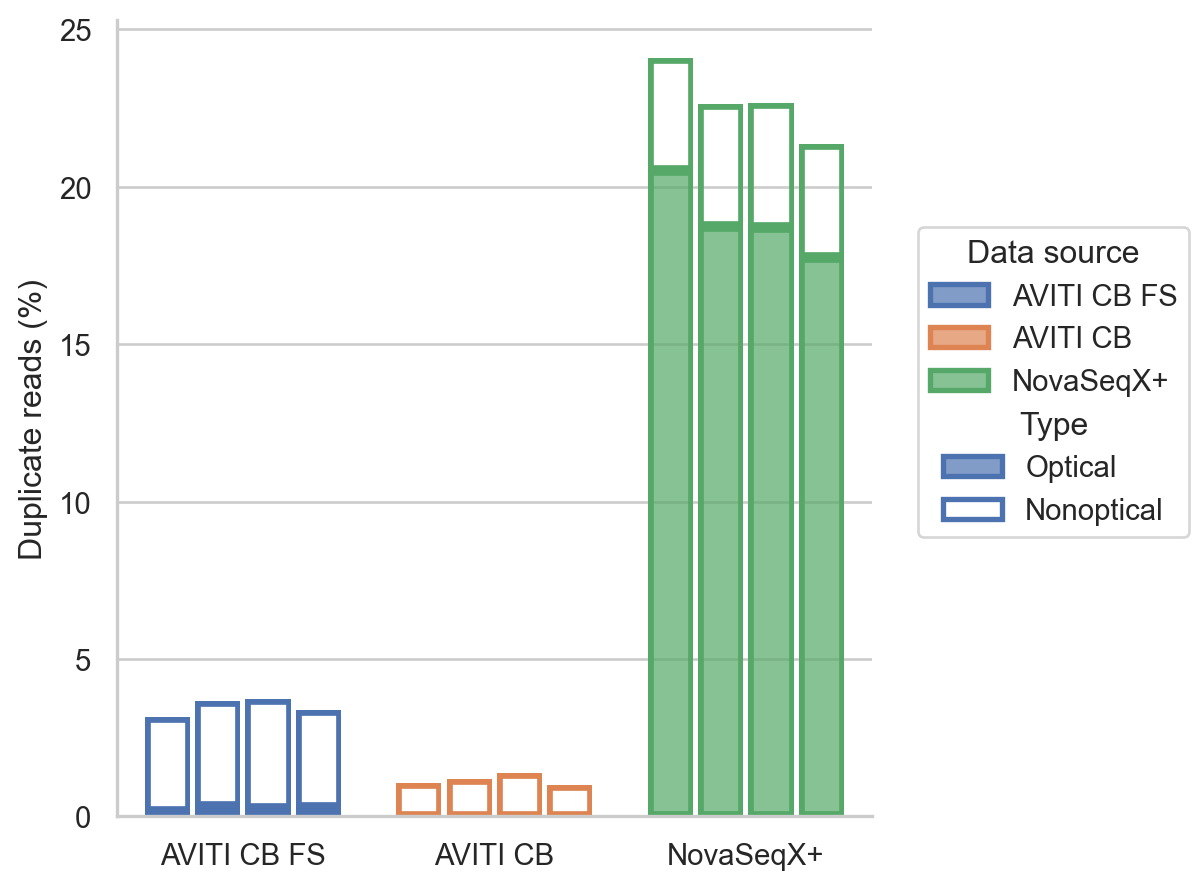

In [3]:
d = dups.melt(id_vars=["Data source", "cell"],
              value_vars=["Optical", "Nonoptical"],
              var_name="Type", value_name="value")

d = d.sort_values(by=["Type", "cell"], ascending=[False, False])
p = (
    so.Plot(data=d, x="Data source", y="value", color="Data source", group="cell")
    .add(so.Bar(edgewidth=2), so.Dodge(by=["cell"],  gap=0.1), so.Stack(), fill="Type")
    .scale(
        color=so.Nominal(order=list(run_names.values())),
    )
    .layout(size=(4.8, 4.8), engine="tight")#, extent=[0, 0, 0.9, 1])
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("notebook"))
    .theme(custom_params)
    .label(
        x="",
        y="Duplicate reads (%)",
    )
    .save(figdir / "duplicate_rates_mapped_reads.svg", dpi=300, bbox_inches="tight", transparent=True)
)
p


## Duplicate classifications

In [4]:
stats = []
for file in sorted(Path("../analysis/chr20_duplicates/dups").glob("*stats.txt")):
    d = pd.read_csv(file, sep=":", names=["Stat", "Value"])
    run = "_".join(file.stem.split("_")[:2])
    d["run"] = run
    cell = file.stem.split("_")[2].split(".")[0]
    d["cell"] = cell
    d["Stat"] = d["Stat"].str.strip()
    stats.append(d)

stats = pd.concat(stats)
stats["Data source"] = stats["run"].replace(run_names)
stats

,Stat,Value,run,cell,Data source
0,Pair combos,79518.0,aviti_hq,KMS12BM,AVITI CB
1,Pair combos Prox+Compl,194.0,aviti_hq,KMS12BM,AVITI CB
2,Pair combos Prox+noCompl,1115.0,aviti_hq,KMS12BM,AVITI CB
3,Pair combos noProx+Compl,72307.0,aviti_hq,KMS12BM,AVITI CB
4,Pair combos noProx+noCompl,5902.0,aviti_hq,KMS12BM,AVITI CB
...,...,...,...,...,...
7,PctPair combos noProx+Compl,14.0,xplus_sns,REH,NovaSeqX+
8,PctPair combos noProx+noCompl,1.2,xplus_sns,REH,NovaSeqX+
9,Read pairs,5635169.0,xplus_sns,REH,NovaSeqX+
10,Read pairs ds=2,3628150.0,xplus_sns,REH,NovaSeqX+


In [5]:
combos = stats[stats["Stat"].str.startswith("Pair combos")]
combos.pivot(index=["Data source", "cell"], columns="Stat", values="Value")

Stat                 Pair combos  Pair combos Prox+Compl  \
Data source cell                                           
AVITI CB    KMS12BM      79518.0                   194.0   
            MM1S         68982.0                   176.0   
            OPM2         67435.0                   167.0   
            REH          58505.0                   143.0   
AVITI CB FS KMS12BM     160467.0                   402.0   
            MM1S        142060.0                   325.0   
            OPM2        173794.0                   446.0   
            REH         108932.0                   281.0   
NovaSeqX+   KMS12BM    4648582.0                  1858.0   
            MM1S       4150121.0                  1583.0   
            OPM2       5054761.0                  1964.0   
            REH        4338037.0                  1871.0   

Stat                 Pair combos Prox+noCompl  Pair combos noProx+Compl  \
Data source cell                                                          
AVITI CB    KMS12BM                    1115.0                   72307.0   
            MM1S                       1031.0                   60753.0   
            OPM2                       1291.0                   61432.0   
            REH                         842.0                   53251.0   
AVITI CB FS KMS12BM                   18380.0                  140770.0   
            MM1S                      15014.0                  125581.0   
            OPM2                      21515.0                  150784.0   
            REH                        8703.0                   99298.0   
NovaSeqX+   KMS12BM                 3839095.0                  740034.0   
            MM1S                    3450755.0                  637896.0   
            OPM2                    4183195.0                  795901.0   
            REH                     3677419.0                  606336.0   

Stat                 Pair combos noProx+noCompl  
Data source cell                                 
AVITI CB    KMS12BM                      5902.0  
            MM1S                         7022.0  
            OPM2                         4545.0  
            REH                          4269.0  
AVITI CB FS KMS12BM                       915.0  
            MM1S                         1140.0  
            OPM2                         1049.0  
            REH                           650.0  
NovaSeqX+   KMS12BM                     67595.0  
            MM1S                        59887.0  
            OPM2                        73701.0  
            REH                         52411.0

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63391/4104608563.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  combos["Data_cell"] = combos[["Data source", "cell"]].apply(lambda x: f"{x[0]} ({x[1]})", axis=1)


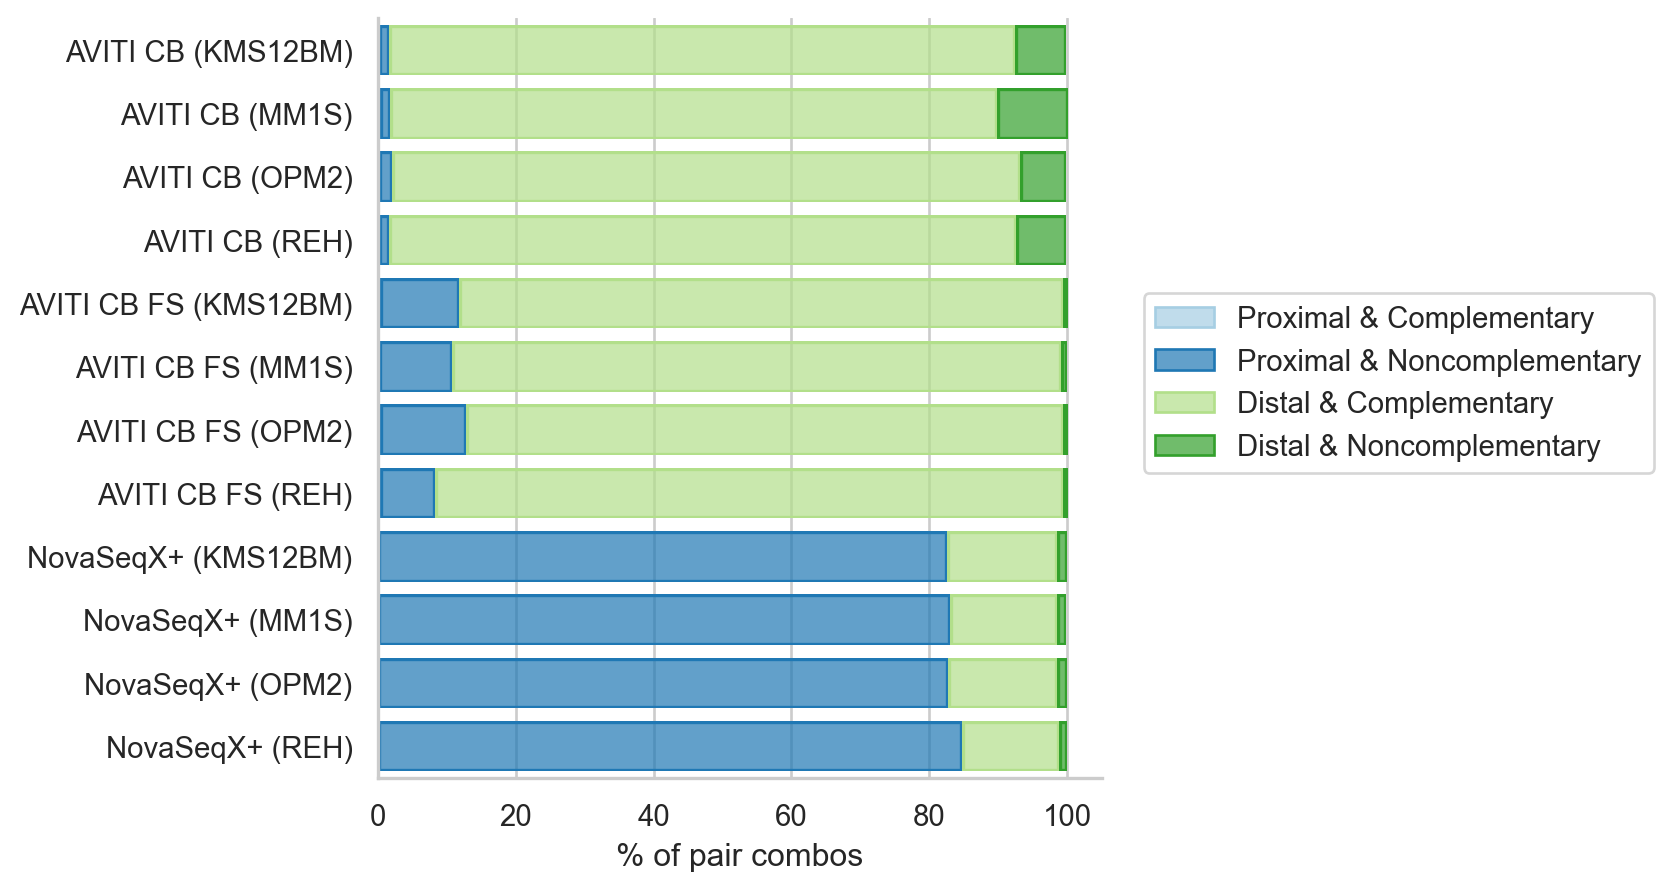

In [6]:
combos = stats[stats["Stat"].str.startswith("PctPair combos")].copy()
combos.loc[:, "Stat"] = combos.loc[:, "Stat"].replace(to_replace={
    "PctPair combos Prox+Compl": "Proximal & Complementary",
    "PctPair combos Prox+noCompl": "Proximal & Noncomplementary",
    "PctPair combos noProx+Compl": "Distal & Complementary",
    "PctPair combos noProx+noCompl": "Distal & Noncomplementary",
})
combos["Data_cell"] = combos[["Data source", "cell"]].apply(lambda x: f"{x[0]} ({x[1]})", axis=1)
p = (
    so.Plot(data=combos, y="Data_cell", x="Value", color="Stat")
    .add(so.Bar(), so.Stack())
    .label(x="% of pair combos", y="", color="")
    .layout(size=(6, 4.8), engine="tight")#, extent=[0, 0, 0.9, 1])
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("notebook"))
    .theme(custom_params)
    .scale(color="Paired")
)
p

## Duplicate distances


In [7]:
dists = []
for file in sorted(Path("../analysis/chr20_duplicates/dups").glob("*distances.txt")):
    with open(file) as f:
        for line in f:            
            if line.startswith("Number of reads:"):
                num_reads_total = int(line.split(":")[1].strip())
            elif line.startswith("Number of reads within tile"):
                num_reads, percentage = line.split(":")[1].strip().split(" ")
                num_reads = int(num_reads)
                percentage = float(percentage.strip("()%"))
            else:
                break
    
    d = pd.read_csv(file, sep="\t", skiprows=2, header=0)
    idx = d.index[d["Distance"] == "Size"][0]
    d = d.iloc[:idx]
    d["Distance"] = d["Distance"].astype(int)
    d["Count"] = d["Count"].astype(int)
    mind = d["Distance"].min()
    d = pd.concat([d, pd.DataFrame({"Distance": list(range(mind)), "Count": [0]*(mind)})])
    d = d.sort_values("Distance")
    run = "_".join(file.stem.split("_")[:2])
    d["run"] = run
    cell = file.stem.split("_")[2].split(".")[0]
    d["cell"] = cell
    d["relative_count"] = d["Count"] / d["Count"].sum()
    d['relative_count_tile'] = d["Count"] / num_reads
    d['relative_count_total'] = d["Count"] / num_reads_total
    d["cumsum"] = d["relative_count"].cumsum()
    d["cumsum_tile"] = d["relative_count_tile"].cumsum()
    d["cumsum_total"] = d["relative_count_total"].cumsum()
    dists.append(d)

    print(run, cell, num_reads, percentage, sep="\t")

dists = pd.concat(dists).reset_index(drop=True)
dists["Data source"] = dists["run"].replace(run_names)
dists


aviti_hq	KMS12BM	2570	0.82
aviti_hq	MM1S	2319	0.85
aviti_hq	OPM2	2809	1.05
aviti_hq	REH	1903	0.82
aviti_ngi	KMS12BM	37302	5.89
aviti_ngi	MM1S	30563	5.44
aviti_ngi	OPM2	43443	6.35
aviti_ngi	REH	18022	4.16
xplus_sns	KMS12BM	5471230	43.01
xplus_sns	MM1S	4819280	43.32
xplus_sns	OPM2	5859850	43.21
xplus_sns	REH	5001406	44.24


,Distance,Count,run,cell,relative_count,relative_count_tile,relative_count_total,cumsum,cumsum_tile,cumsum_total,Data source
0,0,0,aviti_hq,KMS12BM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,AVITI CB
1,1,19,aviti_hq,KMS12BM,1.478599e-02,7.392996e-03,6.027881e-05,0.014786,0.007393,0.000060,AVITI CB
2,2,19,aviti_hq,KMS12BM,1.478599e-02,7.392996e-03,6.027881e-05,0.029572,0.014786,0.000121,AVITI CB
3,3,322,aviti_hq,KMS12BM,2.505837e-01,1.252918e-01,1.021567e-03,0.280156,0.140078,0.001142,AVITI CB
4,4,437,aviti_hq,KMS12BM,3.400778e-01,1.700389e-01,1.386413e-03,0.620233,0.310117,0.002529,AVITI CB
...,...,...,...,...,...,...,...,...,...,...,...
52787,48372,1,xplus_sns,REH,2.698559e-07,1.999438e-07,8.845224e-08,0.999999,0.740927,0.327776,NovaSeqX+
52788,48388,1,xplus_sns,REH,2.698559e-07,1.999438e-07,8.845224e-08,0.999999,0.740927,0.327776,NovaSeqX+
52789,49000,1,xplus_sns,REH,2.698559e-07,1.999438e-07,8.845224e-08,0.999999,0.740928,0.327776,NovaSeqX+
52790,49580,1,xplus_sns,REH,2.698559e-07,1.999438e-07,8.845224e-08,1.000000,0.740928,0.327776,NovaSeqX+


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63391/1588461232.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.lineplot(


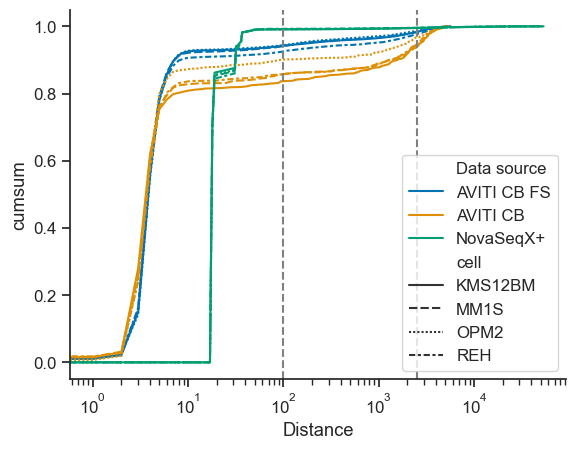

In [8]:
ax = sns.lineplot(
    data=dists,
    x="Distance",
    y="cumsum",
    hue="Data source",
    hue_order=run_names.values(),
    style="cell",
    palette=sns.color_palette("colorblind"),
)
ax.set_xscale("log")
#ax.set_xlim(0, 2500)
ax.axvline(x=100, color="grey", linestyle="--")
ax.axvline(x=2500, color="grey", linestyle="--")

